In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.3 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1


In [3]:
results_file = './write/hccmk.h5ad'

In [4]:
adata = sc.read_10x_mtx('./iPQB/Systems', var_names = 'gene_symbols', cache=True)

... writing an h5ad cache file to speedup reading next time


In [5]:
barcode_meta = pd.read_csv('./iPQB/Systems/MK_barcode_identities.csv', sep=',', index_col=1)

barcode_meta.index = barcode_meta.apply(lambda x: x.name + '-1', axis=1)

print(len(adata.obs.index), len(np.intersect1d(adata.obs.index, barcode_meta.index)))
barcode_meta = barcode_meta.replace({'CTCGGAAT':'LM2-B','TCCCCTTT':'Parental','GGCCGGTT':'LM2-C'}
                                   )
barcode_meta

9525 8864


,Unnamed: 0,multiseq barcode
ATGTGTGTCACAGGCC-1,0,Parental
GCTTCCACACATCTTT-1,1,Parental
CGGCTAGCAGCCAGAA-1,2,LM2-B
GATCGATAGTCATGCT-1,3,Parental
ACACCCTTCCACGCAG-1,4,LM2-B
...,...,...
GGTGTTATCAGGATCT-1,8859,LM2-B
TCACAAGAGCGTTTAC-1,8860,LM2-B
GTAGGCCGTGGTAACG-1,8861,LM2-C
GTAACTGAGTAGGTGC-1,8862,LM2-B


In [6]:
adata.var_names_make_unique()

In [7]:
adata.obs['multiseq'] = barcode_meta.loc[adata.obs.index, 'multiseq barcode']

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


normalizing counts per cell
    finished (0:00:00)


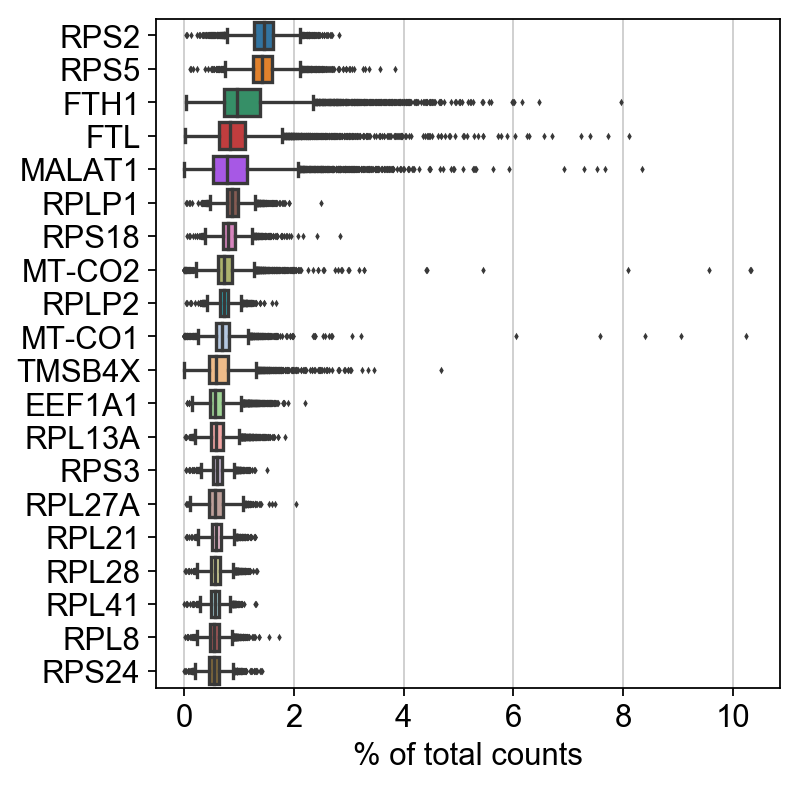

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 13984 genes that are detected in less than 3 cells


In [10]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

... storing 'multiseq' as categorical


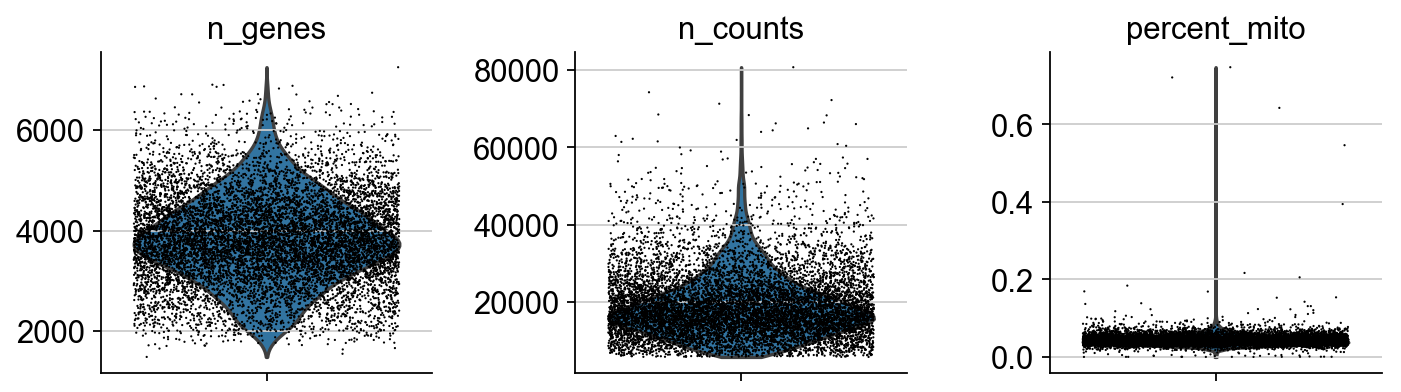

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

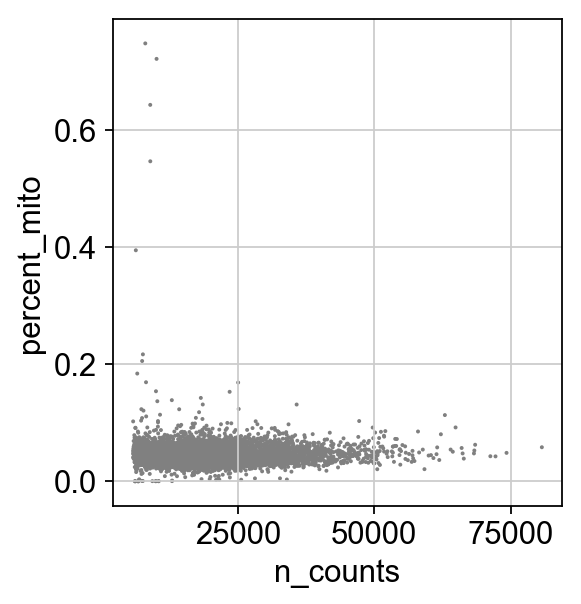

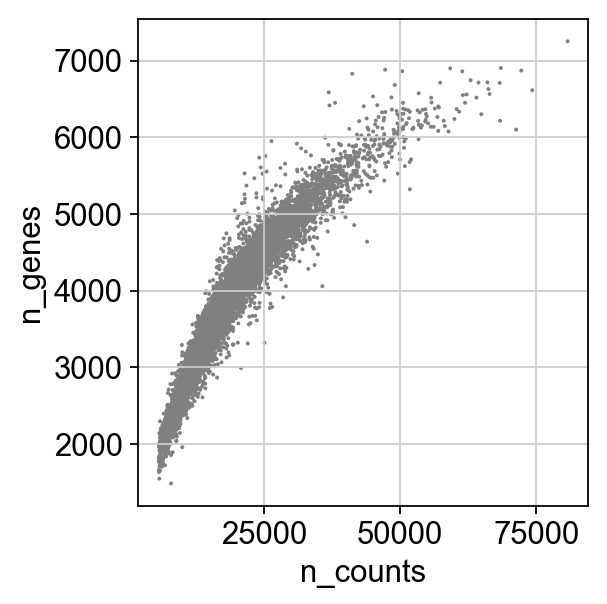

In [12]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [13]:
adata = adata[adata.obs.multiseq != 'nan', :]

In [14]:
adata = adata[adata.obs.n_genes < 6000, :]
adata = adata[adata.obs.percent_mito < 0.07, :]

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


Trying to set attribute `.X` of view, making a copy.


    finished (0:00:45)


In [16]:
sc.pp.log1p(adata)

/usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [17]:
adata.raw = adata

In [18]:
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [19]:
adata.var[adata.var.highly_variable == True]

,gene_ids,n_cells,highly_variable,means,dispersions,dispersions_norm
RP11-54O7.3,ENSG00000223764,228,True,0.015189,-0.224058,0.937505
SAMD11,ENSG00000187634,3566,True,0.294929,0.089550,2.385900
HES4,ENSG00000188290,8482,True,1.096684,0.250717,0.798969
ISG15,ENSG00000187608,9077,True,1.317341,0.395846,0.779849
RNF223,ENSG00000237330,2857,True,0.194364,-0.259600,0.743647
...,...,...,...,...,...,...
TMPRSS3,ENSG00000160183,359,True,0.025514,-0.077982,1.734257
HSF2BP,ENSG00000160207,1502,True,0.095565,-0.281524,0.624068
C21orf58,ENSG00000160298,2569,True,0.168019,-0.285903,0.600184
MT-ND6,ENSG00000198695,7673,True,0.865685,0.257202,1.456625


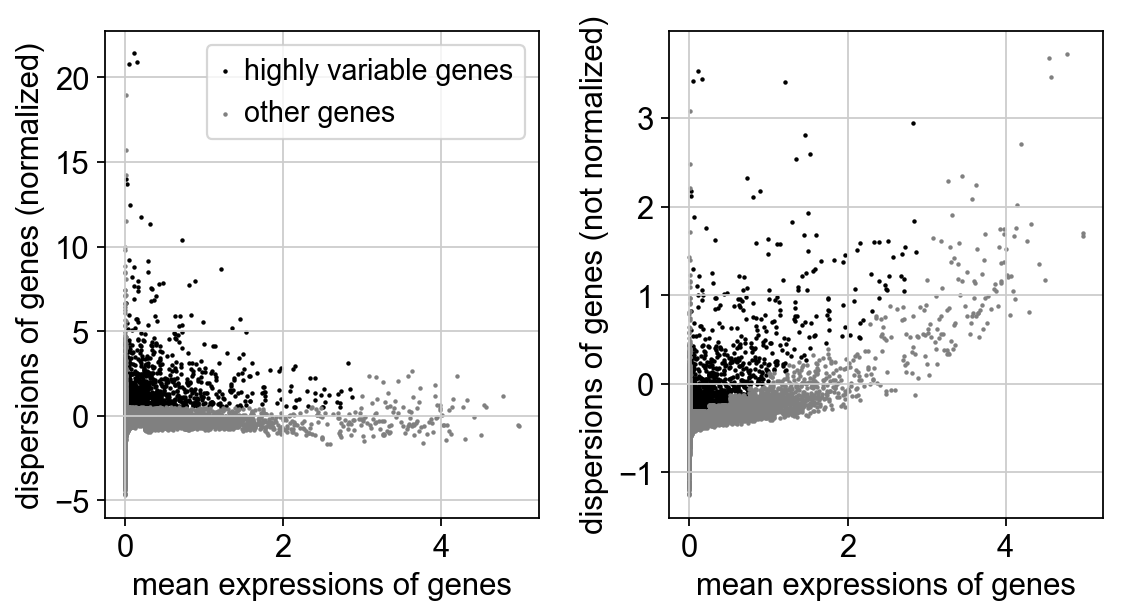

In [20]:
sc.pl.highly_variable_genes(adata)

In [21]:
adata = adata[:, adata.var.highly_variable]

In [22]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:17)


In [23]:
sc.pp.scale(adata, max_value=10)

In [24]:
import urllib.request
cell_cycle_genes = [x.strip().decode('utf-8') for x in urllib.request.urlopen('https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [25]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


... storing 'phase' as categorical


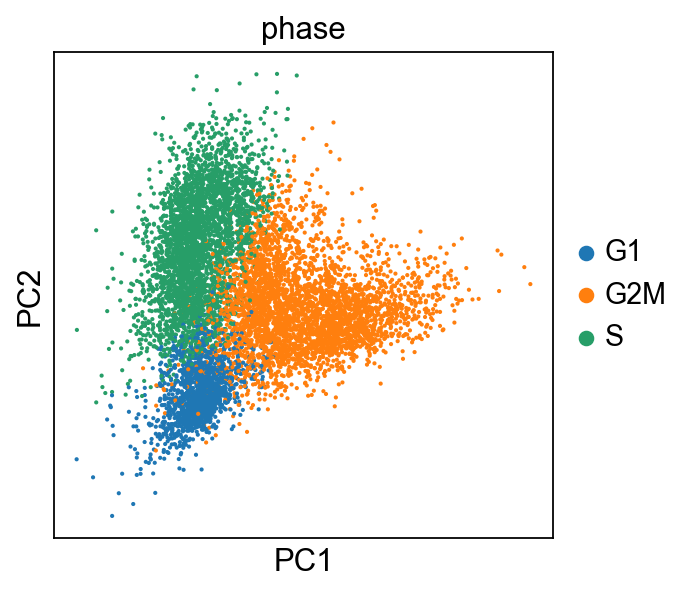

In [26]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [27]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

regressing out ['S_score', 'G2M_score']


... storing 'phase' as categorical


    finished (0:00:14)


computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


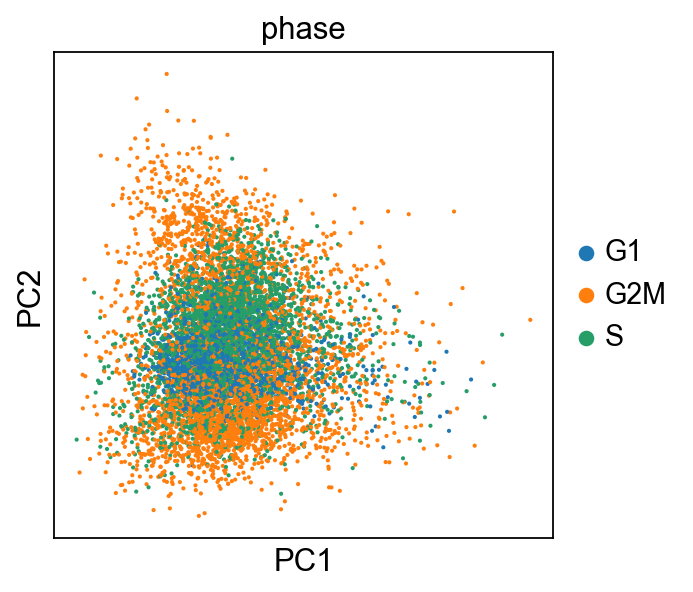

In [28]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [29]:
sc.tl.pca(adata, svd_solver='arpack')


computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:02)


In [30]:
adata

AnnData object with n_obs × n_vars = 8556 × 1441 
    obs: 'multiseq', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

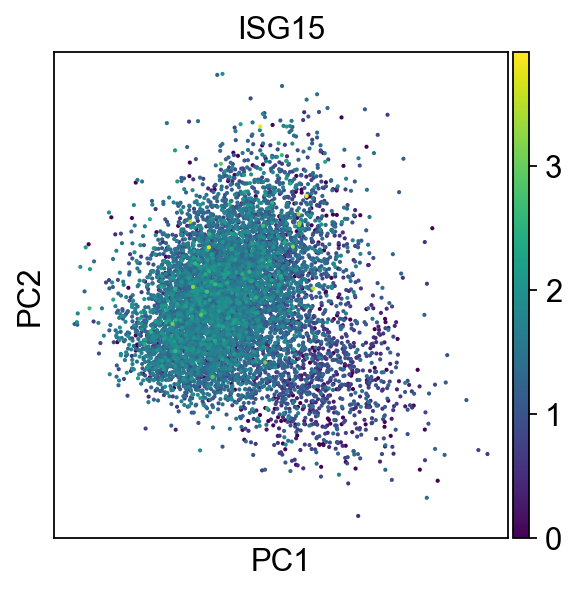

In [31]:
sc.pl.pca(adata, color='ISG15')

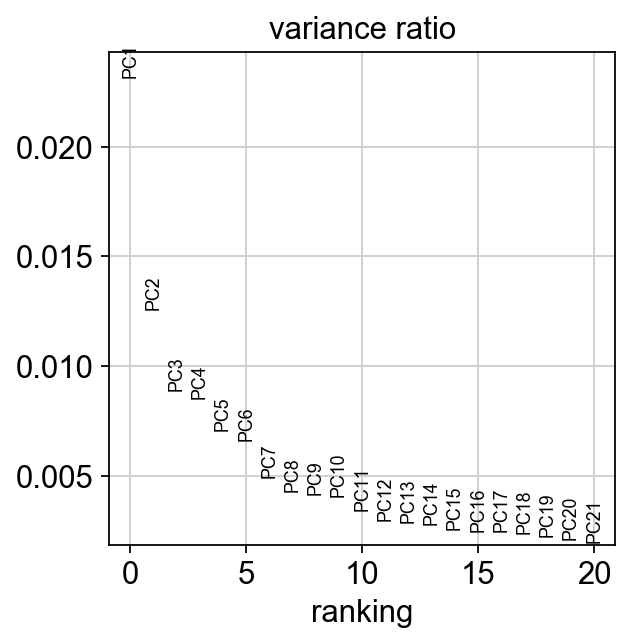

In [32]:
sc.pl.pca_variance_ratio(adata, log=False, n_pcs=20)

In [33]:
adata.write(results_file)

In [34]:
sc.pp.neighbors(adata, n_neighbors=10, knn=True, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10


/usr/local/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(p

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:08)


In [35]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


In [36]:
LM_percent = []
Parental_percent = []
mask = []
mask_three = []
for i in range(0,len(adata)):
    if adata.obs.iloc[i]['multiseq'] == 'Parental':
        neighbours = adata.obs[adata.uns['neighbors']['distances'].toarray()[i]!=0]
        num_LM = len(neighbours[neighbours['multiseq'] != 'Parental'])
        LM_percent.append(num_LM/9.0)
        if num_LM/9.0 >= 0.5:
            mask.append('p-H')
            mask_three.append('p-H')
        else:
            mask.append('p-L')
            mask_three.append('p-L')
    else:
        mask_three.append('LM')
        neighbours = adata.obs[adata.uns['neighbors']['distances'].toarray()[i] != 0]
        num_parental = len(neighbours[neighbours['multiseq'] != 'Parental'])
        Parental_percent.append(num_parental/9.0)
        if num_parental/9.0 < 0.7:
            mask.append('LM-L')
        else:
            mask.append('LM-H')

In [37]:
adata.obs['status'] = mask
adata.obs['three_groups'] = mask_three

In [38]:
len(adata.obs)

8556

... storing 'status' as categorical
... storing 'three_groups' as categorical


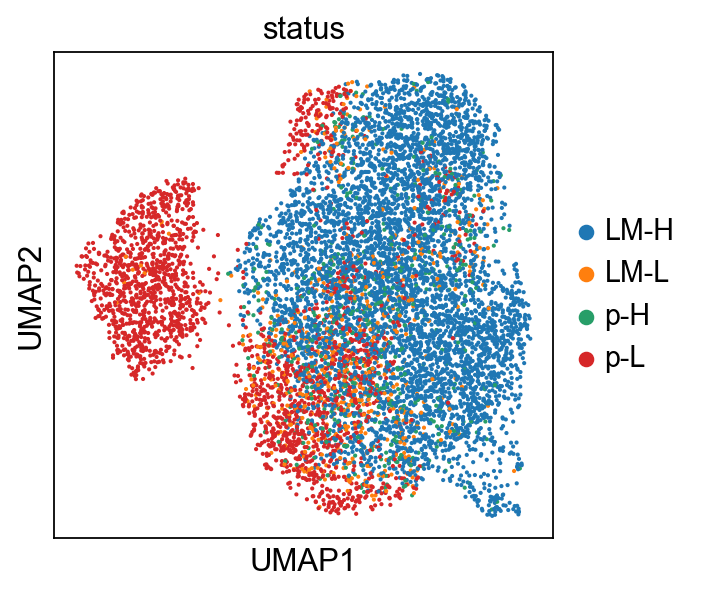

In [39]:
sc.pl.umap(adata, color=['status'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:16)


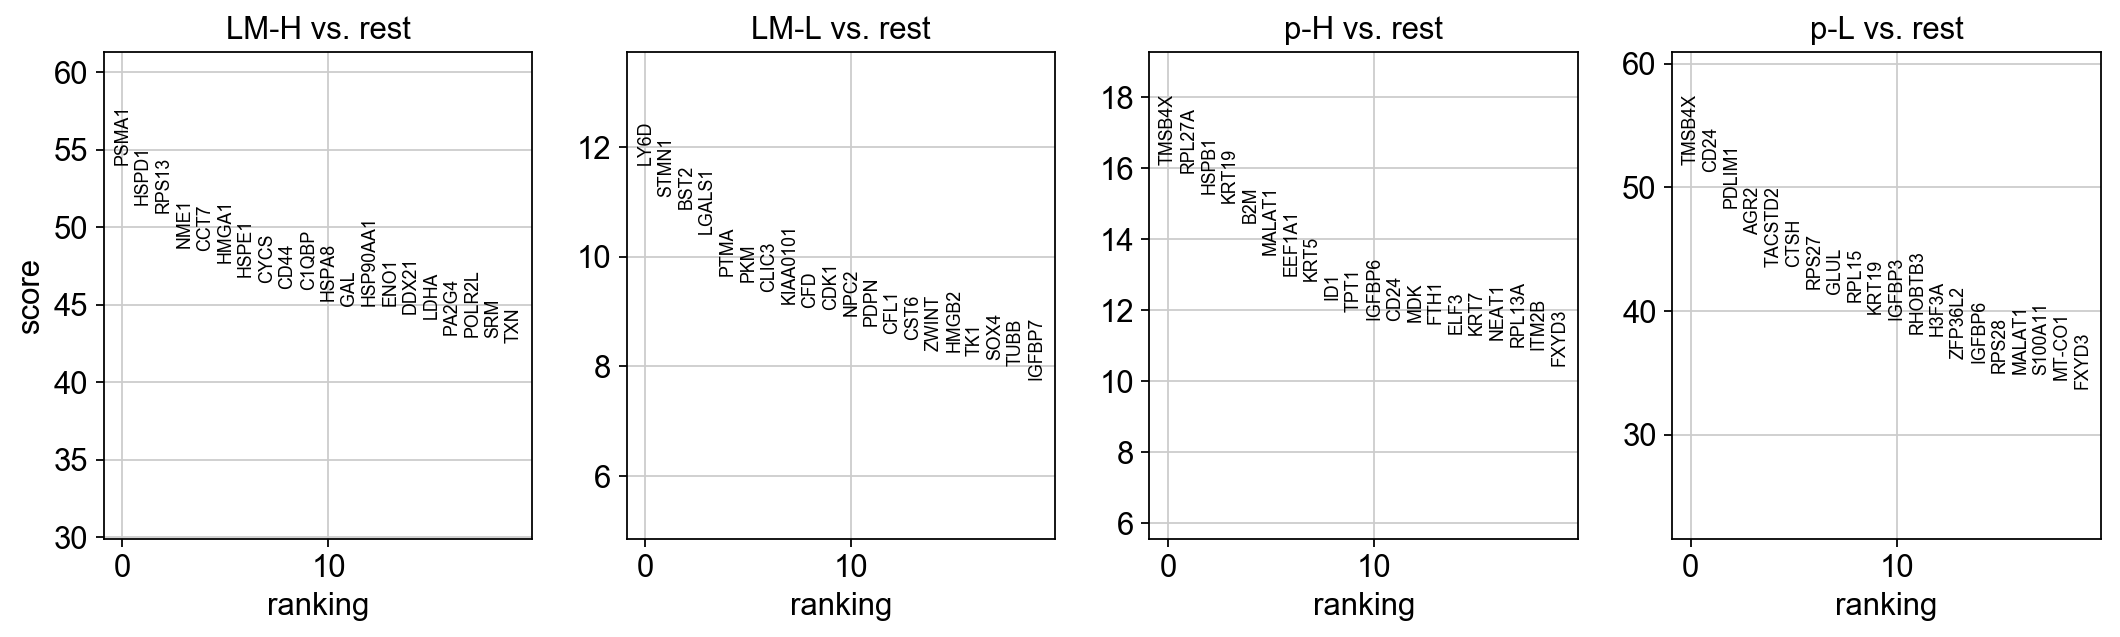

In [41]:
sc.tl.rank_genes_groups(adata, 'status', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


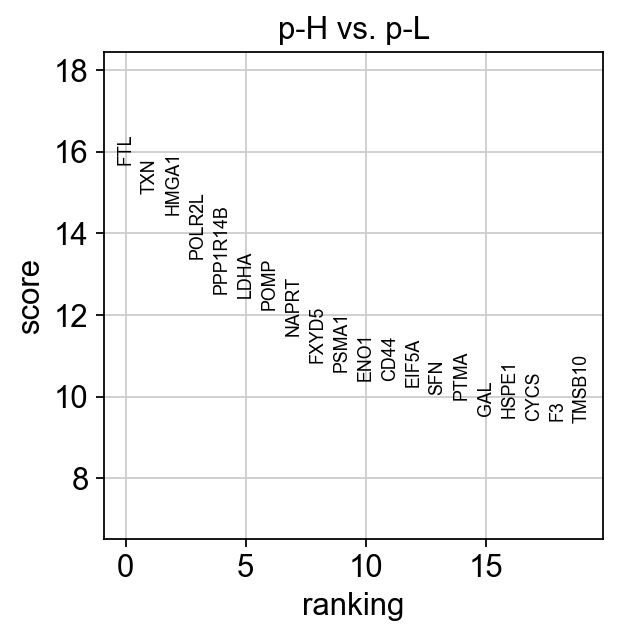

In [42]:
sc.tl.rank_genes_groups(adata, 'status', groups=["p-H"], reference='p-L', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=["p-H"], n_genes=20)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


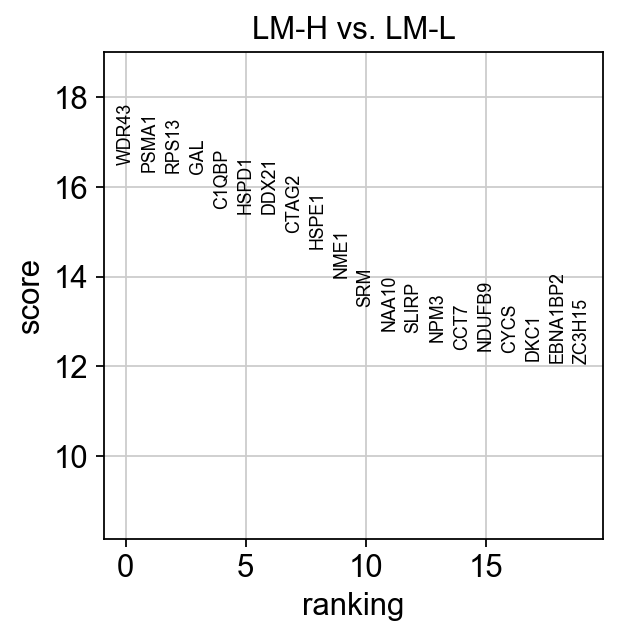

In [43]:
sc.tl.rank_genes_groups(adata, 'status', groups=["LM-H"], reference='LM-L', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=["LM-H"], n_genes=20)

In [44]:
adata.uns['rank_genes_groups']['names']['LM-H']

array(['WDR43', 'PSMA1', 'RPS13', 'GAL', 'C1QBP', 'HSPD1', 'DDX21',
       'CTAG2', 'HSPE1', 'NME1', 'SRM', 'NAA10', 'SLIRP', 'NPM3', 'CCT7',
       'NDUFB9', 'CYCS', 'DKC1', 'EBNA1BP2', 'ZC3H15', 'RPL10', 'RSL1D1',
       'ATP5G3', 'EIF3J', 'NPM1', 'HMGA1', 'ENO1', 'NOP16', 'RAN', 'PNO1',
       'LDHA', 'NIFK', 'BCAP31', 'MYC', 'NCL', 'CCT4', 'MAGEA4', 'PSMA7',
       'SNRPG', 'HSP90AB1', 'KRT18', 'PSMD14', 'GTPBP4', 'CYC1', 'TIMM13',
       'FOSL1', 'CHCHD10', 'AIMP2', 'EIF3I', 'NOL7', 'EIF5A', 'PHB',
       'BOP1', 'SNRPF', 'PPP1R14B', 'PPA1', 'PFDN2', 'ZNF593', 'TAF10',
       'NHP2', 'NACA', 'PPIF', 'GLRX3', 'PRELID1', 'DCAF13', 'HPRT1',
       'BOLA3', 'HSP90AA1', 'COA6', 'MRPL33', 'FJX1', 'POMP', 'CEBPZ',
       'HSPA8', 'SSB', 'UTP14A', 'RPF2', 'LSM7', 'SERBP1', 'FHL1',
       'MRPS25', 'SSR4', 'NDUFAF4', 'PA2G4', 'APRT', 'EIF2S2', 'PSMD3',
       'EIF3B', 'MAP7D3', 'CD3EAP', 'RPL8', 'PCBD1', 'UBE2M', 'ATP5G1',
       'PSMA5', 'TRMT112', 'PDCD5', 'CCT6A', 'COA4', 'LTV1'], dtype

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


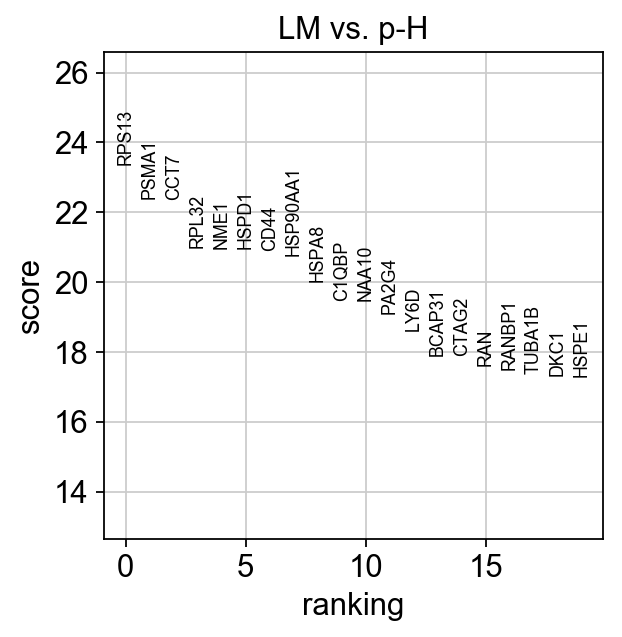

In [45]:
sc.tl.rank_genes_groups(adata, 'three_groups', groups=['LM'], reference='p-H', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['LM'], n_genes=20)

In [46]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


In [47]:
x = adata.obs.groupby(by = ['leiden', 'multiseq']).size() / adata.obs.groupby(by = 'leiden').size()

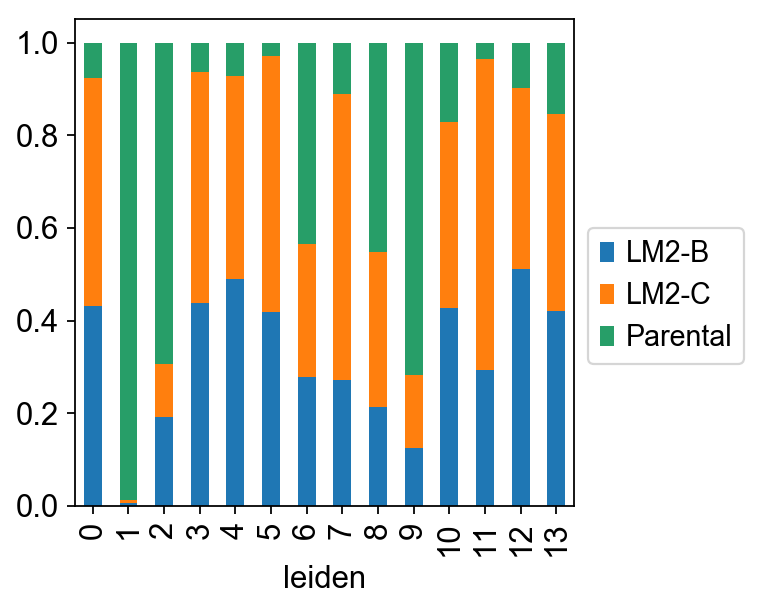

In [48]:
ax = x.unstack().plot(kind='bar', stacked=True)
ax.legend(bbox_to_anchor=(1,.6))
ax.grid(b=None)

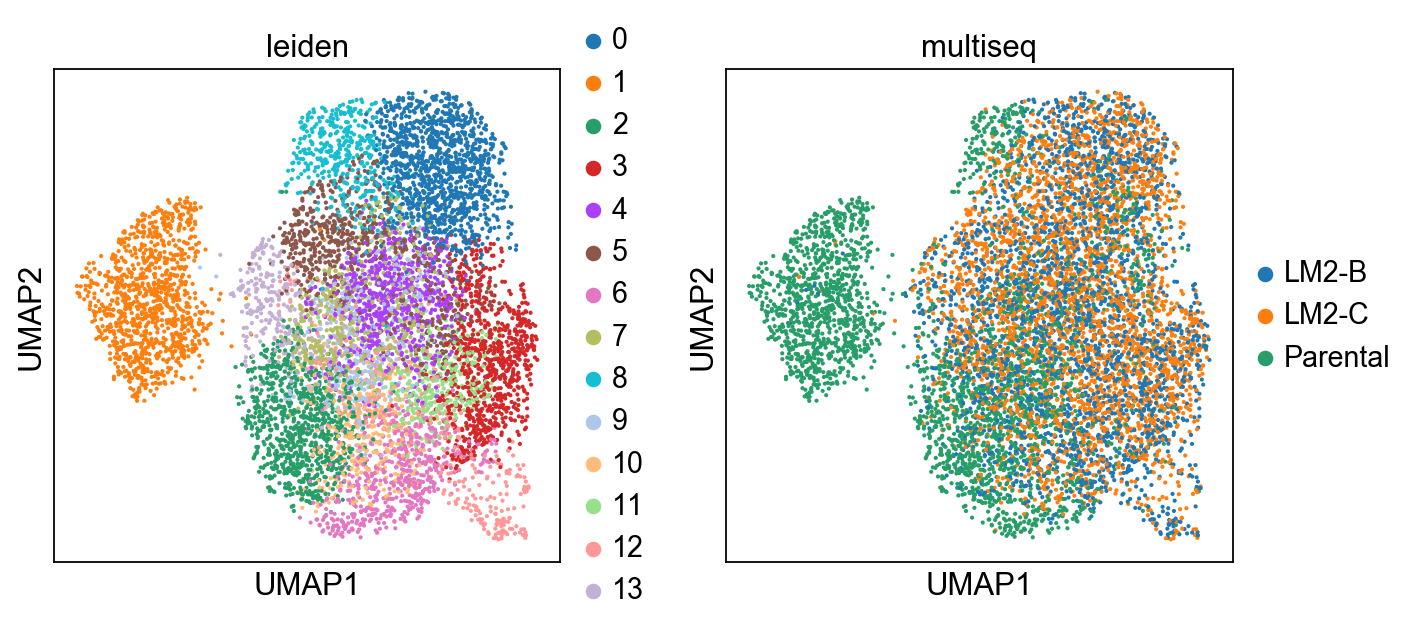

In [49]:
sc.pl.umap(adata, color=['leiden', 'multiseq'])

In [50]:
adata.write(results_file)

In [51]:
adata_Parental = adata[adata.obs.multiseq == 'Parental', :]

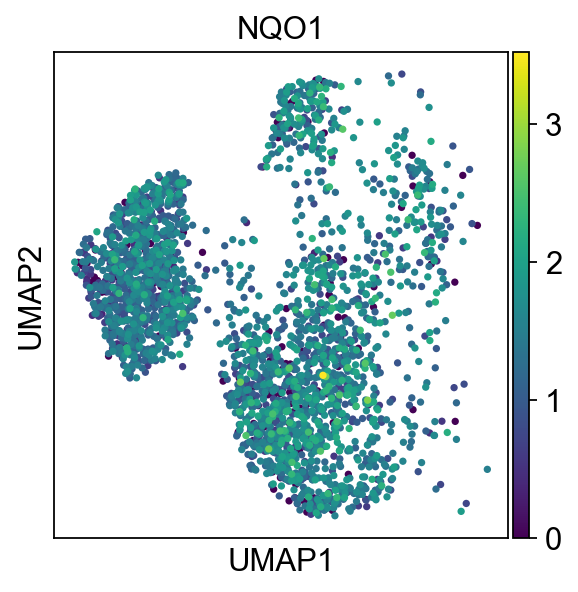

In [52]:
sc.pl.umap(adata_Parental, color = 'NQO1')

In [53]:
adata_NONP = adata[adata.obs.multiseq != 'Parental',:]

In [54]:
sc.tl.leiden(adata_NONP, resolution=0.7, key_added = 'NonParental_leiden')

running Leiden clustering


Trying to set attribute `.obs` of view, making a copy.


    finished: found 18 clusters and added
    'NonParental_leiden', the cluster labels (adata.obs, categorical) (0:00:04)


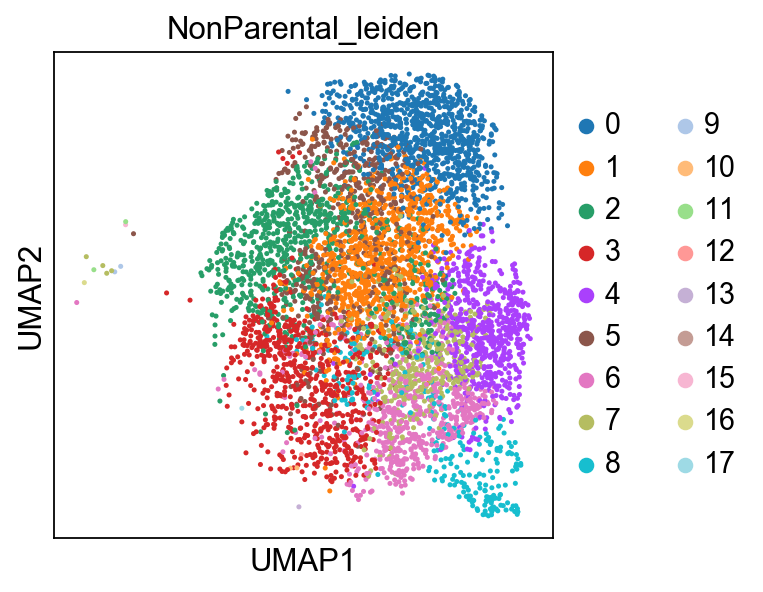

In [55]:
sc.pl.umap(adata_NONP, color='NonParental_leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


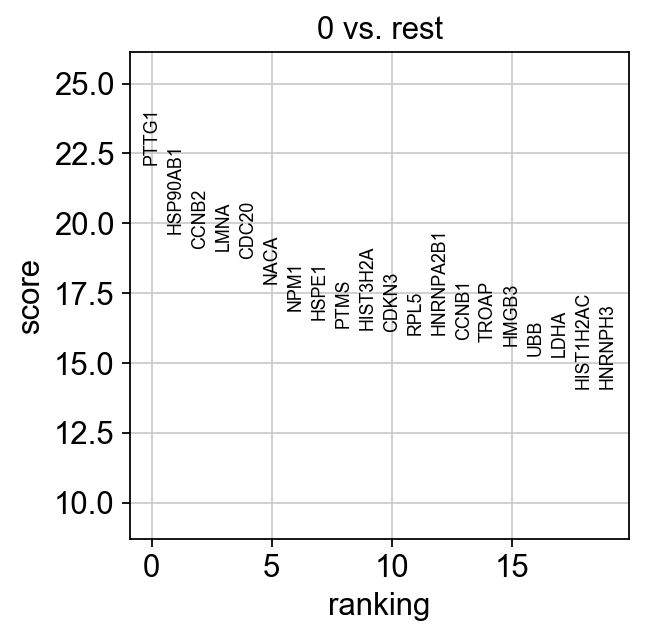

In [56]:
sc.tl.rank_genes_groups(adata_NONP, 'NonParental_leiden', groups=['0'], method='wilcoxon')
sc.pl.rank_genes_groups(adata_NONP, groups=['0'], n_genes=20)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


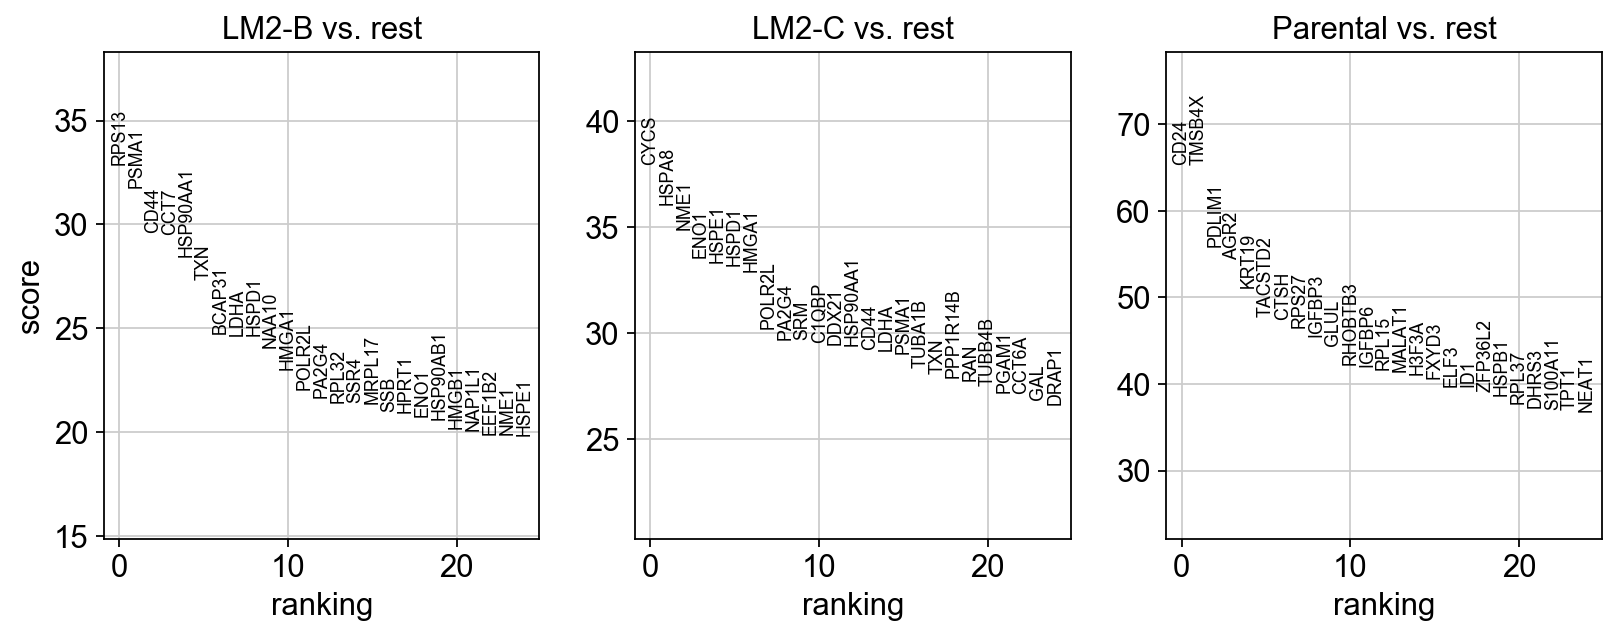

In [57]:
sc.tl.rank_genes_groups(adata, 'multiseq', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [58]:
sc.settings.verbosity=2

ranking genes
    finished (0:00:15)


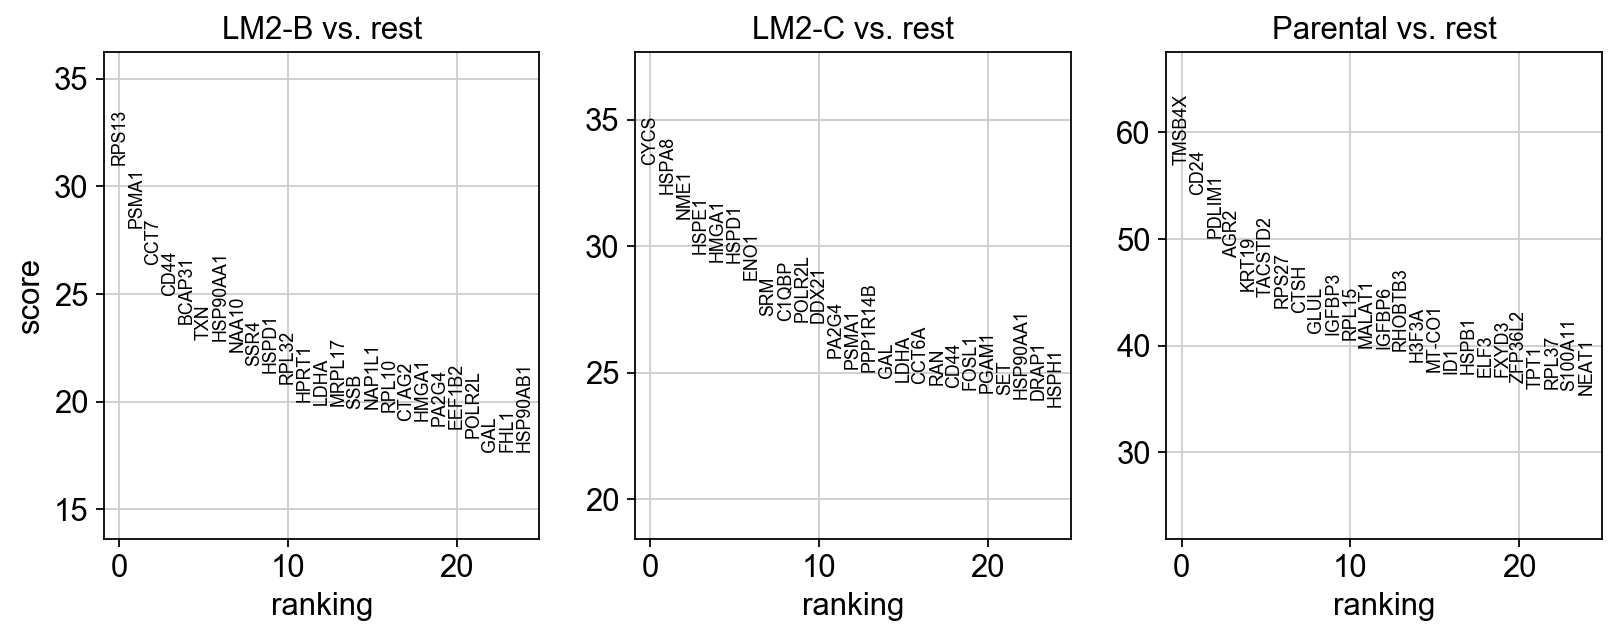

In [59]:
sc.tl.rank_genes_groups(adata, 'multiseq', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [60]:
adata.write(results_file)

ranking genes
    finished (0:00:51)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


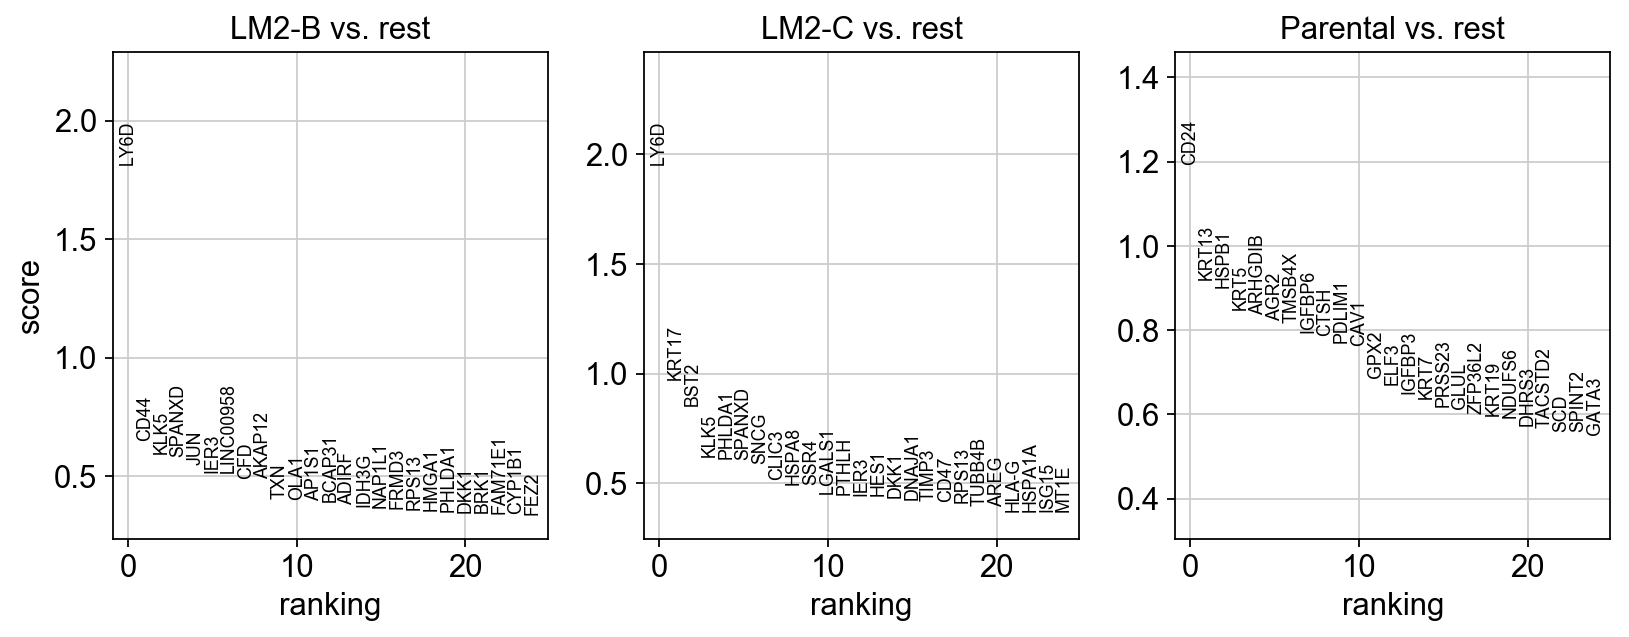

In [61]:
sc.tl.rank_genes_groups(adata, 'multiseq', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)